# Data Import

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

if os.getenv("SNAKEMAKE_EXECUTION"):
    # Adjust paths for Snakemake execution
    db_path = "02-Data_Curation/unified-curated.db"
else:
    # Adjust paths for local execution
    db_path = "../02-Data_Curation/unified-curated.db"


con = sqlite3.connect(db_path)
    
cur = con.cursor()

df = pd.read_sql_query("SELECT * FROM prod", con)
df

,index,id,name,AB,description,OX,source,seq,valid
0,0,DRAMP02488; P0DI85,dramp_DRAMP02488; OXLA8_DEIAC,1,L-amino-acid oxidase ACTX-8 (Fragment),alien; Deinagkistrodon acutus OX=36307,dramp_antimicrobial.fasta; uniprot_swissprot.f...,ADDRNPLEEFRENNYEEFL,yes - merged duplicate
1,1,ADAM_0078; P86520,InverPep_ADAM_0078; SBTXA_SOYBN,1,Soybean toxin 27 kDa chain (Fragment),alien; Glycine max OX=3847,InverPep.fasta; uniprot_swissprot.fasta,ADPTFGFTPLGLSEKANLQIMKAYD,yes - merged duplicate
2,2,ADAM_0131; P81493,InverPep_ADAM_0131; DFAX1_BETVU,1,Defensin-like protein AX1,alien; Beta vulgaris OX=161934,InverPep.fasta; uniprot_swissprot.fasta,AICKKPSKFFKGACGRDADCEKACDQENWPGGVCVPFLRCECQRSC,yes - merged duplicate
3,3,ADAM_0141; P84644,InverPep_ADAM_0141; CIRF_CHAPA,1,Circulin-F,alien; Chassalia parviflora OX=58431,InverPep.fasta; uniprot_swissprot.fasta,AIPCGESCVWIPCISAAIGCSCKNKVCYR,yes - merged duplicate
4,4,ADAM_0221; P80278,InverPep_ADAM_0221; DRS2_PHYSA,1,Dermaseptin-S2,alien; Phyllomedusa sauvagei OX=8395,InverPep.fasta; uniprot_swissprot.fasta,ALWFTMLKKLGTMALHAGKAALGAAANTISQGTQ,yes - merged duplicate
...,...,...,...,...,...,...,...,...,...
11558,11558,Q3E778,YB96B_YEAST,0,Uncharacterized protein YBR196C-B,Saccharomyces cerevisiae (strain ATCC 204508 /...,uniprot_swissprot.fasta,MWVVLSKEKILLKKAYYAKTILFSALVLRGVRGE,yes
11559,11559,Q3E781,YB221_YEAST,0,Uncharacterized protein YBR221W-A,Saccharomyces cerevisiae (strain ATCC 204508 /...,uniprot_swissprot.fasta,MFSHFEVSENRPRKQPRRKRISLGMINTVVSLDR,yes
11560,11560,Q3E7Z3,YI018_YEAST,0,Uncharacterized protein YIR018C-A,Saccharomyces cerevisiae (strain ATCC 204508 /...,uniprot_swissprot.fasta,MPSDYTSHYPVILIKKKKKKIAGMYRHSKRYLEIMSTASAQFVGN,yes
11561,11561,Q3E7Z6,YH015_YEAST,0,Uncharacterized protein YHL015W-A,Saccharomyces cerevisiae (strain ATCC 204508 /...,uniprot_swissprot.fasta,MTAFASLREPLVLANLKIKVHIYRMKR,yes


# Compare Positive/negative Data
To ensure a model does not determine the AB of a seq based on something else the seq information we try to match as many properties of data. Goal is to avoid that we train a model which just discriminates based on length or some property similiar.

In [3]:
pd.read_sql_query("SELECT COUNT(*), AB FROM prod GROUP BY AB", con)

,COUNT(*),AB
0,5499,0
1,6064,1


This is close enough to a 1:1 ratio. This ensures that potential models do not determine the activity by guessing based on length.

# Compare lengths


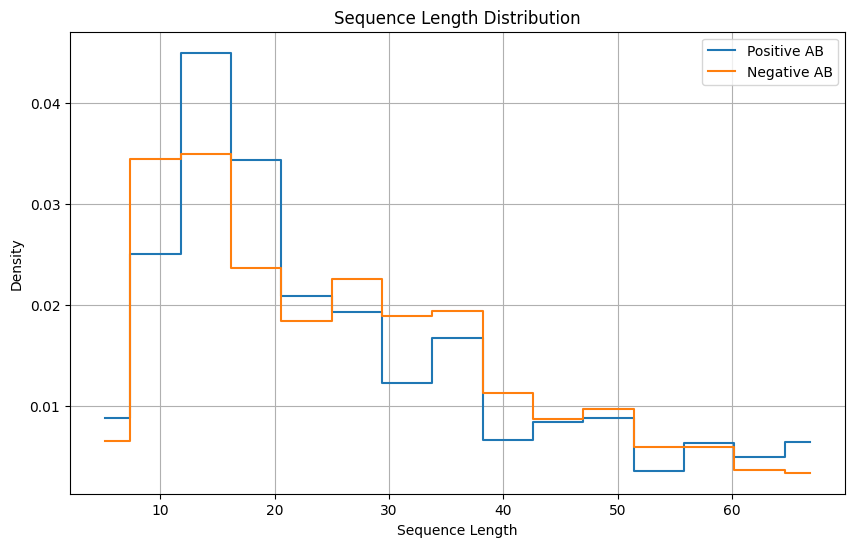

<Figure size 640x480 with 0 Axes>

In [4]:
# Calculate lengths
df['seq_length'] = df['seq'].apply(lambda x: len(x))

# Separate by AB values
positive = df[df['AB'] == 1]
negative = df[df['AB'] == 0]

# Calculate histogram data
hist_data_pos, bin_edges_pos = np.histogram(positive['seq_length'], bins=15, density=True)
hist_data_neg, bin_edges_neg = np.histogram(negative['seq_length'], bins=15, density=True)

# Midpoints of bins
bin_centers_pos = 0.5 * (bin_edges_pos[1:] + bin_edges_pos[:-1])
bin_centers_neg = 0.5 * (bin_edges_neg[1:] + bin_edges_neg[:-1])

# Create line plot
plt.figure(figsize=(10, 6))
plt.plot(bin_centers_pos, hist_data_pos, label='Positive AB', drawstyle='steps-mid')
plt.plot(bin_centers_neg, hist_data_neg, label='Negative AB', drawstyle='steps-mid')
plt.legend()
plt.title('Sequence Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Density')
plt.grid(True)
plt.show()
plt.savefig("seqLengthDistribution.pdf")

The length destribution is roughly the same. Meaning models cant guess based on sequence length.

# AA make up
Goal check wether AA make up is the same with positive AB and negative AB.

   mean_pos   std_pos  mean_neg   std_neg
A  0.072133  0.081133  0.071409  0.072438
C  0.046886  0.072192  0.057424  0.086726
D  0.022232  0.041434  0.047820  0.056307
E  0.027636  0.047318  0.042314  0.055501
F  0.046443  0.059670  0.049525  0.058696
G  0.077392  0.076602  0.089425  0.073278
H  0.021238  0.045240  0.018015  0.033728
I  0.060642  0.066154  0.049651  0.055316
K  0.122173  0.114791  0.066316  0.068974
L  0.111131  0.106703  0.081242  0.077912
M  0.012943  0.027911  0.022257  0.035804
N  0.030543  0.040114  0.041477  0.047771
P  0.045159  0.078188  0.062563  0.074483
Q  0.023317  0.040609  0.032233  0.046809
R  0.084391  0.114989  0.055445  0.075592
S  0.047624  0.055000  0.062233  0.058034
T  0.034906  0.047349  0.045240  0.050738
V  0.055728  0.061321  0.058343  0.057309
W  0.035163  0.078596  0.015686  0.033631
Y  0.022320  0.042012  0.031381  0.043478


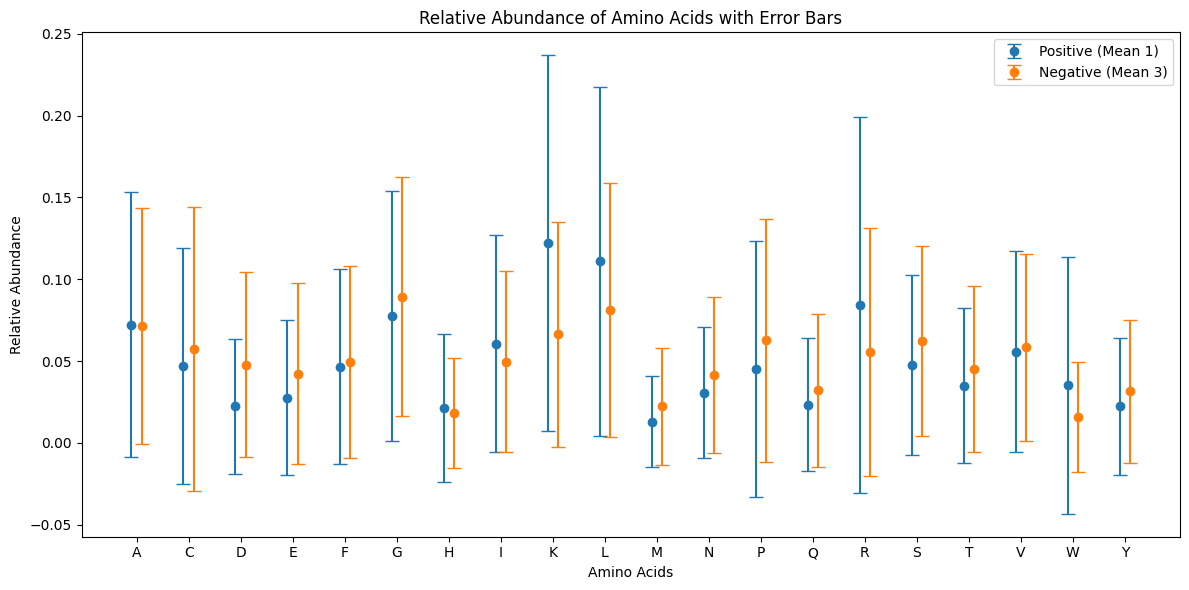

<Figure size 640x480 with 0 Axes>

In [5]:
# Calculate relative abundance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is provided
df_backup = df.copy()

# List of amino acids
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')

# Function to calculate relative abundance of amino acids
def calculate_abundance(seq):
    abundance = {aa: 0 for aa in amino_acids}
    for aa in seq:
        if aa in abundance:
            abundance[aa] += 1
    seq_length = len(seq)
    if seq_length > 0:
        for aa in abundance:
            abundance[aa] /= seq_length
    return abundance

# Apply the function to each sequence and create a new DataFrame
abundance_df = df['seq'].apply(calculate_abundance).apply(pd.Series)

# Merge the new DataFrame with the original DataFrame
result_df = pd.concat([df['AB'], abundance_df], axis=1)

# Separate positive and negative groups
positive = result_df[result_df['AB'] == 1].drop(columns=['AB']).reset_index(drop=True)
negative = result_df[result_df['AB'] == 0].drop(columns=['AB']).reset_index(drop=True)

n_pos = len(positive)
n_neg = len(negative)

# Calculate means and standard deviations
df_local = pd.concat([positive.mean(), positive.std(), negative.mean(), negative.std()], axis=1)
df_local.columns = ['mean_pos', 'std_pos', 'mean_neg', 'std_neg']
df_local.index = amino_acids

print(df_local)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# X-axis positions for the amino acids
x = np.arange(len(df_local))

# Plotting data points and error bars
ax.errorbar(x - 0.1, df_local['mean_pos'], yerr=df_local['std_pos'], fmt='o', label='Positive (Mean 1)', capsize=5)
ax.errorbar(x + 0.1, df_local['mean_neg'], yerr=df_local['std_neg'], fmt='o', label='Negative (Mean 3)', capsize=5)

# Setting the labels and title
ax.set_xlabel('Amino Acids')
ax.set_ylabel('Relative Abundance')
ax.set_title('Relative Abundance of Amino Acids with Error Bars')

# Setting the x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(df_local.index)

# Adding legend
ax.legend()

# Displaying the plot
plt.tight_layout()
plt.show()
plt.savefig("AA-makeup.pdf")


Graphic shows no large deviation per amino acid postive vs negative.

In [ ]:
import os
if os.getenv("SNAKEMAKE_EXECUTION"):
    import shutil
    shutil.move("seqLengthDistribution.pdf", "03-EDA/seqLengthDistribution.pdf")
    shutil.move("AA-makeup.pdf", "03-EDA/AA-makeup.pdf")